## Practice dataset: Airlines Arrival

Use this dataset of airline arrival information to predict how late flights will be. A flight only counts as late if it is more than 30 minutes late.

Primary question: 
- Outcome of interest: Whether an arriving flight will be on time or delayed. 


Secondary outcomes: 
- When is a good time to fly or when flights are least delayed? 
- List of  airlines that are more prone to the delay? 
- What are the primary factors that cause/ related to the delay? 

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Import sklearn models 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score
from sklearn import linear_model
from sklearn.metrics import confusion_matrix


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv('2008.csv')

In [3]:
df.shape # 7 mln datapoints, 29 variables including the outcome variable
#random sampling to 25% for computational efficiency

(7009728, 29)

In [4]:
sample = df.sample(frac=0.25, replace=True, random_state=111)

In [5]:
sample.shape  # 1.75 mln datapoints, 29 variables

(1752432, 29)

In [6]:
sample.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
3616596,2008,7,6,7,649.0,655,807.0,815,WN,468,...,8.0,16.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
6945644,2008,12,7,7,834.0,835,1403.0,1430,AS,20,...,6.0,18.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4728788,2008,8,4,1,1954.0,1715,129.0,2250,AA,794,...,8.0,25.0,0,NaN,0,0.0,0.0,2.0,0.0,157.0
4330196,2008,8,18,1,1326.0,1335,1427.0,1442,XE,430,...,4.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2199638,2008,4,24,4,2017.0,1910,2209.0,2055,MQ,4502,...,5.0,22.0,0,NaN,0,36.0,0.0,7.0,0.0,31.0


In [7]:
sample.describe()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,1752432.0,1.752432e+06,1.752432e+06,1.752432e+06,1.718472e+06,1.752432e+06,1.714614e+06,1.752432e+06,1.752432e+06,1.713870e+06,...,1.752432e+06,1.714614e+06,1.718263e+06,1.752432e+06,1.752432e+06,380791.000000,380791.000000,380791.000000,380791.000000,380791.000000
mean,2008.0,6.377964e+00,1.573477e+01,3.924709e+00,1.333708e+03,1.326068e+03,1.481187e+03,1.494558e+03,2.224662e+03,1.272535e+02,...,7.258026e+02,6.859805e+00,1.644132e+01,1.955568e-02,2.449168e-03,15.834156,3.048412,17.235055,0.071422,20.729319
std,0.0,3.407132e+00,8.795838e+00,1.989233e+00,4.781821e+02,4.642054e+02,5.050018e+02,4.824917e+02,1.961511e+03,7.014678e+01,...,5.616410e+02,4.930965e+00,1.133278e+01,1.384676e-01,4.942844e-02,39.950477,19.148238,32.173666,1.887592,39.117848
min,2008.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.600000e+01,...,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2008.0,3.000000e+00,8.000000e+00,2.000000e+00,9.280000e+02,9.250000e+02,1.107000e+03,1.115000e+03,6.220000e+02,7.700000e+01,...,3.250000e+02,4.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2008.0,6.000000e+00,1.600000e+01,4.000000e+00,1.325000e+03,1.320000e+03,1.512000e+03,1.517000e+03,1.571000e+03,1.090000e+02,...,5.800000e+02,6.000000e+00,1.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,6.000000,0.000000,0.000000
75%,2008.0,9.000000e+00,2.300000e+01,6.000000e+00,1.728000e+03,1.715000e+03,1.909000e+03,1.906000e+03,3.518000e+03,1.570000e+02,...,9.510000e+02,8.000000e+00,1.900000e+01,0.000000e+00,0.000000e+00,16.000000,0.000000,21.000000,0.000000,26.000000
max,2008.0,1.200000e+01,3.100000e+01,7.000000e+00,2.400000e+03,2.359000e+03,2.400000e+03,2.400000e+03,9.741000e+03,1.379000e+03,...,4.962000e+03,2.330000e+02,4.290000e+02,1.000000e+00,1.000000e+00,1552.000000,1148.000000,1357.000000,392.000000,925.000000


In [8]:
sample.columns #'ArrDelay' is the variable of interest, value in minutes

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [9]:
sample.ArrDelay.describe() #ArrDelay in - means arrived early, should be excluded  

count    1.713870e+06
mean     8.169415e+00
std      3.843001e+01
min     -8.700000e+01
25%     -1.000000e+01
50%     -2.000000e+00
75%      1.200000e+01
max      1.583000e+03
Name: ArrDelay, dtype: float64

In [6]:
sample = sample[sample.ArrDelay >=1]

In [7]:
# sns.distplot(sample.ArrDelay) # column has null values 

# All flights that are cancelled or diverted have null values 
sample.groupby(['Cancelled', 'Diverted'])['ArrDelay'].describe()


,,count,mean,std,min,25%,50%,75%,max
Cancelled,Diverted,,,,,,,,
0,0,744484.0,32.207029,47.994276,1.0,6.0,15.0,38.0,1583.0


In [8]:
# Dropping rows of 'Cancelled' and 'Diverted' flights
sample = sample[(sample.Cancelled==0) & (sample.Diverted==0)]

In [24]:
sample[['ArrDelay', 'ArrTime', 'CRSArrTime']].head()

,ArrDelay,ArrTime,CRSArrTime
4728788,159.0,129.0,2250
2199638,74.0,2209.0,2055
1732726,51.0,1731.0,1640
3905490,51.0,2050.0,1959
168903,20.0,1038.0,1018


In [10]:
sample.ArrDelay.isnull().sum()  # now no null values for Arrival Delay

sample.isnull().sum() # this also removes other null values 

Year                      0
Month                     0
DayofMonth                0
DayOfWeek                 0
DepTime                   0
CRSDepTime                0
ArrTime                   0
CRSArrTime                0
UniqueCarrier             0
FlightNum                 0
TailNum                   0
ActualElapsedTime         0
CRSElapsedTime            0
AirTime                   0
ArrDelay                  0
DepDelay                  0
Origin                    0
Dest                      0
Distance                  0
TaxiIn                    0
TaxiOut                   0
Cancelled                 0
CancellationCode     744484
Diverted                  0
CarrierDelay         363693
WeatherDelay         363693
NASDelay             363693
SecurityDelay        363693
LateAircraftDelay    363693
dtype: int64

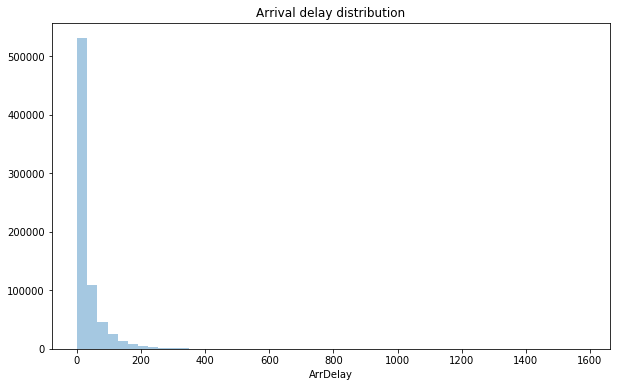

In [23]:
plt.figure(figsize=(10,6))
sns.distplot(sample.ArrDelay, bins=50, kde=False)
plt.title('Arrival delay distribution')
plt.show()

(-10, 800)

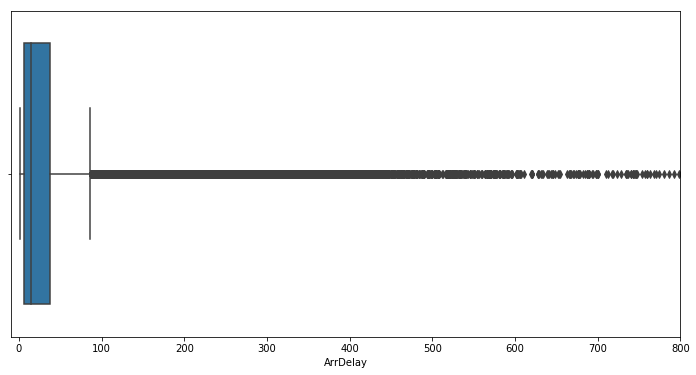

In [30]:
plt.figure(figsize=(12,6))
sns.boxplot(sample.ArrDelay)
plt.xlim(-10,800)

# Most delay are within the 100 minutes

### Exploratory Data visualization

Let's take a look at how arrival delay is related to other variables. 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


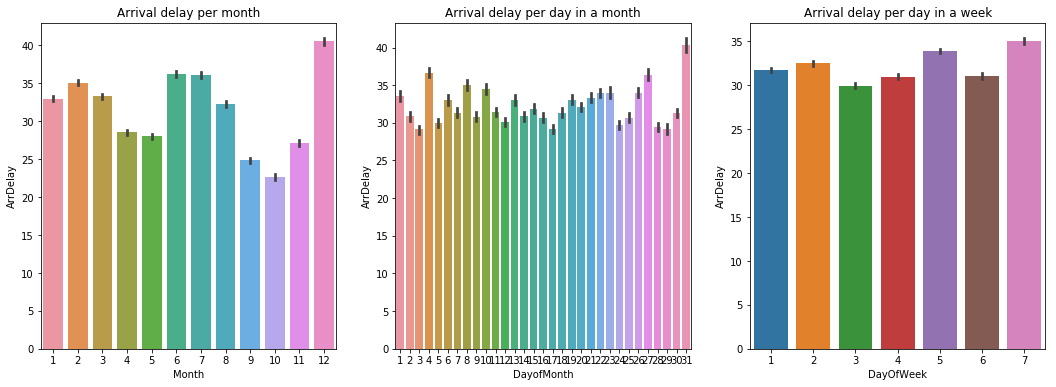

In [34]:
# Arrival delay and time

plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
sns.barplot(data=sample, x='Month', y='ArrDelay')
plt.title('Arrival delay per month')

plt.subplot(1,3,2)
sns.barplot(data=sample, x='DayofMonth', y='ArrDelay')
plt.title('Arrival delay per day in a month')


plt.subplot(1,3,3)
sns.barplot(data=sample, x='DayOfWeek', y='ArrDelay')
plt.title('Arrival delay per day in a week')
plt.show()


- Flights in December are delayed the most, while flights in September, October and November are generally not delayed. 

- Day of the month and day of the week are not a significant indicator of arrival delay. 


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


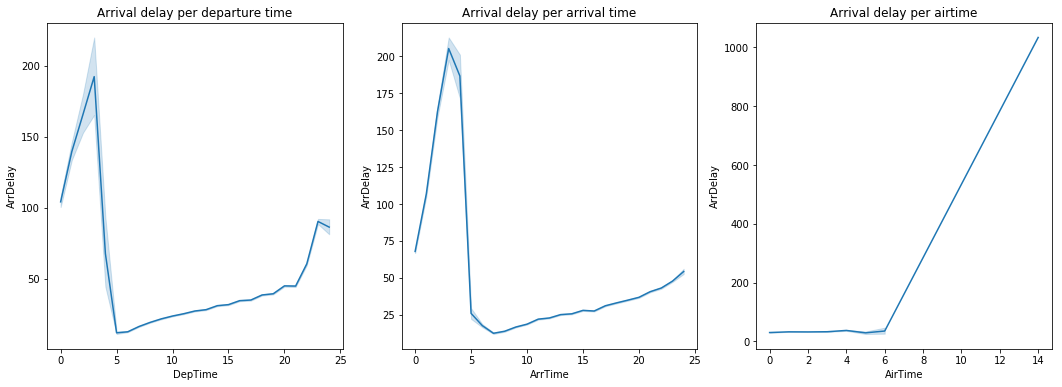

In [35]:
# Arrival delay and time

plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
sns.lineplot(x=round(sample.DepTime/100, 0), y=sample.ArrDelay, markers=True)
plt.title('Arrival delay per departure time')

plt.subplot(1,3,2)
sns.lineplot(x=round(sample.ArrTime /100, 0), y=sample.ArrDelay, markers=True)
plt.title('Arrival delay per arrival time')


plt.subplot(1,3,3)
sns.lineplot(x=round(sample.AirTime/100, 0), y=sample.ArrDelay, markers=True)
plt.title('Arrival delay per airtime')
plt.show()


- Flights departing and arriving between midnight and 5 am are delayed the most. 

- Flights longer than 6 hours of airtime also arrived delayed. The longer the airtime, longer is the propensity of delay. 

In [17]:
sample.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [37]:
delay_variables = sample[['ArrDelay','DepDelay', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']]

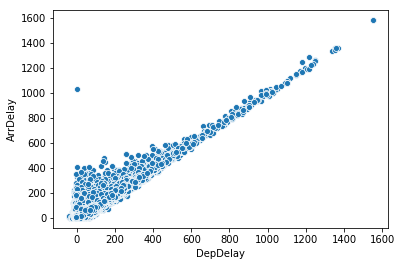

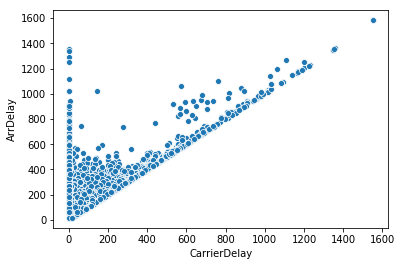

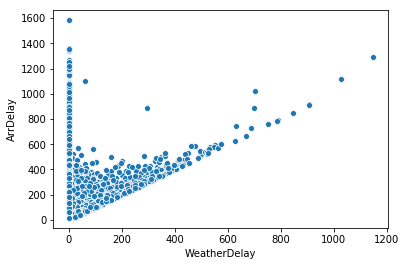

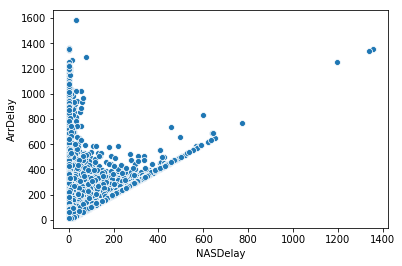

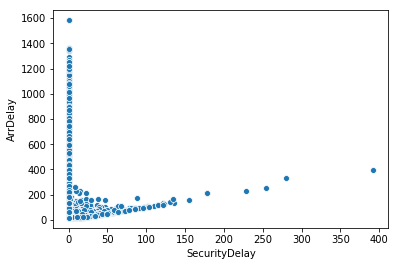

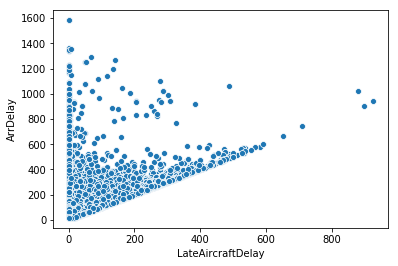

In [38]:
for col in delay_variables.columns[1:]:
 #   print(col)
    sns.scatterplot(data=delay_variables, y='ArrDelay', x=col)
    plt.show()
    
# DepDelay, CarrierDelay and LateAircraftDelay seems to have linear relations with ArrDelay

In [39]:
# Reassigning delay_Variables

delay_variables = sample[['ArrDelay','DepDelay', 'CarrierDelay','LateAircraftDelay']]

In [54]:
delay_variables.isna().sum()

ArrDelay                  0
DepDelay                  0
CarrierDelay         363693
LateAircraftDelay    363693
dtype: int64

In [52]:
delay_variablesq = delay_variables.fillna(0)  # fill missing delay variables with 0 as 
# missing delay value = no delay = 0 delay 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


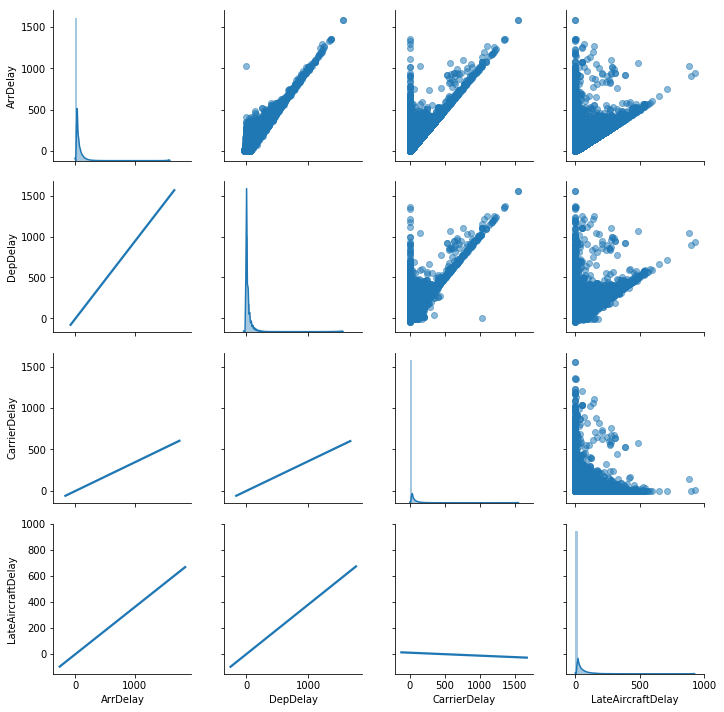

In [55]:
#plt.figure(figsize=(12,8))

#Declare scatterplot matrix
g = sns.PairGrid(delay_variablesq, diag_sharey=False)

#Set upper matrix to scatter
g.map_upper(plt.scatter, alpha=.5)

#Set lower matrix to regression lines
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

#Set diagonals to distribution plot
g.map_diag(sns.distplot)
plt.show()

In [43]:
# Selecting a subset with arrival delay wrt carrier, origin and destination
sample_1 = sample[['ArrDelay', 'UniqueCarrier', 'FlightNum', 'TailNum', 'Origin', 'Dest']]

# Selecting only positive delays, not early arrivals (in negative values)
sample_1 = sample_1[sample_1.ArrDelay >= 0]

In [44]:
sample_1.head()

,ArrDelay,UniqueCarrier,FlightNum,TailNum,Origin,Dest
4728788,159.0,AA,794,N4WPAA,LAS,ORD
2199638,74.0,MQ,4502,N626AE,ORD,AZO
1732726,51.0,B6,87,N651JB,JFK,SLC
3905490,51.0,US,1712,N713UW,FLL,DCA
168903,20.0,OH,5360,N786CA,ORD,JFK


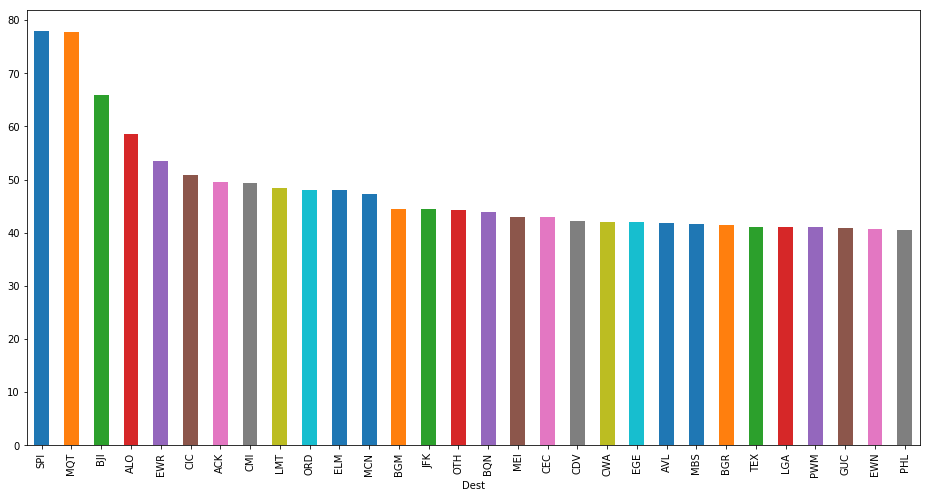

In [49]:
# top 30 airports with most arrival delay 
plt.figure(figsize=(16,8))
sample_1.groupby(['Dest'])['ArrDelay'].mean().sort_values(ascending=False).head(30).plot(kind='bar')

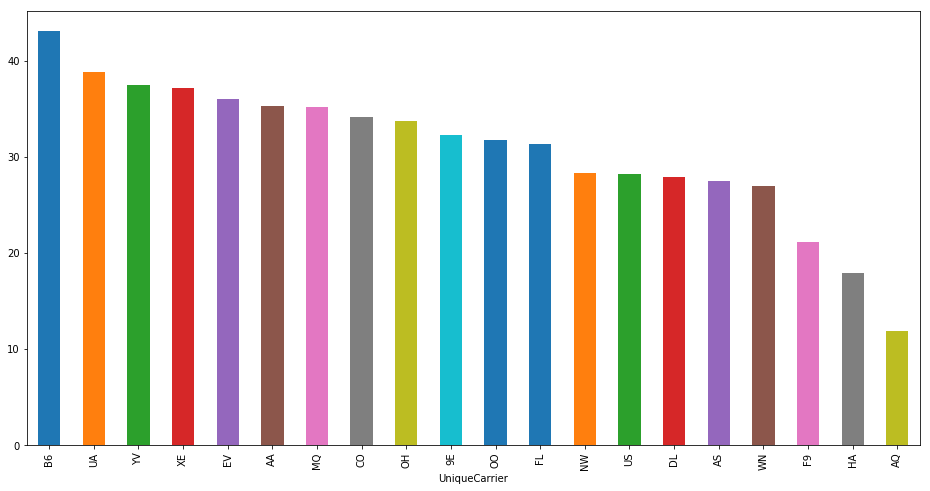

In [56]:
# top 20 unique carriers with most arrival delay 
plt.figure(figsize=(16,8))
sample_1.groupby(['UniqueCarrier'])['ArrDelay'].mean().sort_values(ascending=False).head(30).plot(kind='bar')

In [46]:
# select a subset of columns - removing features that are not relevant

sample = sample.drop(['Year', 'Cancelled', 'CancellationCode', 'Diverted'], 
                    axis=1)


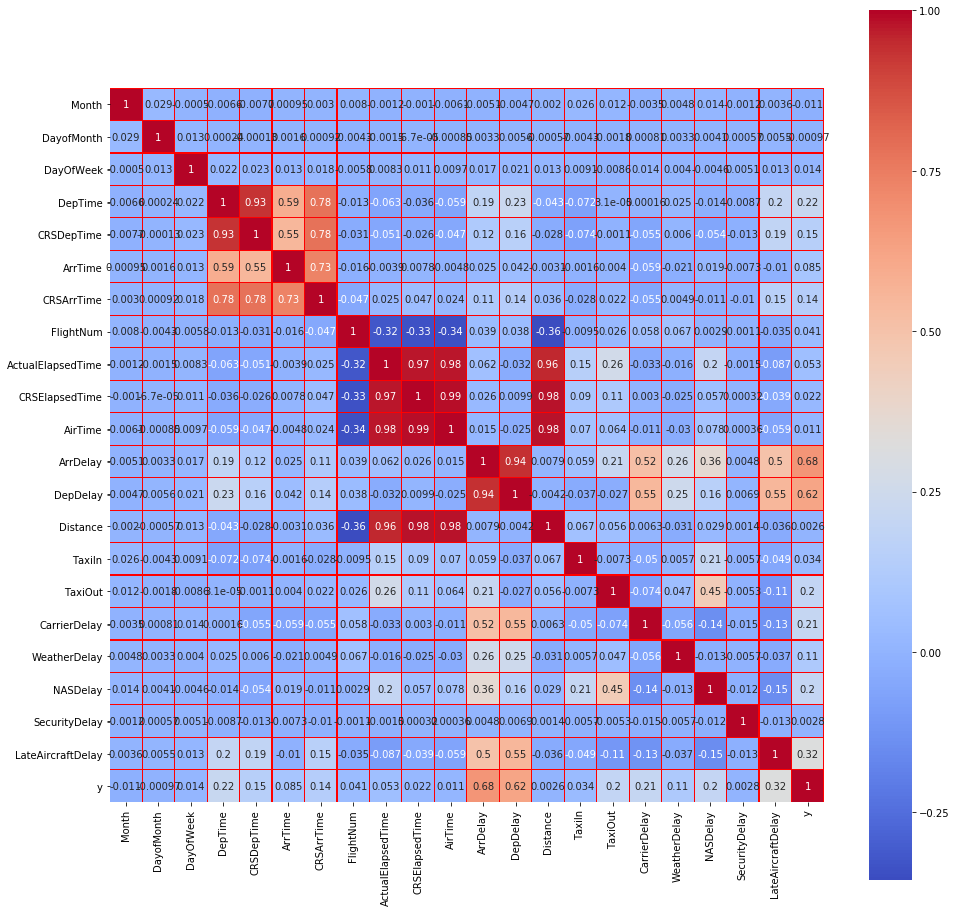

In [59]:
# Let's look at the correlations among the variables

plt.figure(figsize=(16,16))
sns.heatmap(sample.corr(), cmap='coolwarm', square=True, annot=True, 
            linecolor='red', vmax=1, linewidth=.1)

## Running models to see the baseline accuracy

In [60]:
# creating the y variable for classification. 
# Required criterion: A flight only counts as late if it is more than 30 minutes late.

sample['y'] = np.where(sample['ArrDelay']>30, 1, 0)

In [61]:
# Creating X and y

X = sample.drop('y', axis=1)
y = sample.y

In [64]:
# checking for null values 

X.isnull().sum()

# All delay values have same null values, filling those with 0 as no delay = 0 delay 

X = X.fillna(0)

In [65]:
# Checking null values again 
X.isnull().sum()

Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
UniqueCarrier        0
FlightNum            0
TailNum              0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
TaxiIn               0
TaxiOut              0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
dtype: int64

In [70]:
# Also checking for string values 

X.describe()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,...,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,744484.000000,744484.000000,744484.000000,744484.000000,744484.000000,744484.000000,744484.000000,744484.000000,744484.000000,744484.000000,...,744484.000000,744484.000000,744484.000000,744484.000000,744484.000000,744484.000000,744484.000000,744484.000000,744484.000000,744484.000000
mean,6.145266,15.730671,3.940463,1411.134759,1381.291570,1538.807612,1550.908318,2191.716539,137.935906,132.267978,...,32.207029,26.539102,753.251676,7.657747,20.296513,8.098903,1.559211,8.815440,0.036531,10.602697
std,3.459580,8.770594,1.981045,478.646452,454.693819,532.364218,478.351572,1957.282173,73.710558,71.024434,...,47.994276,48.191011,573.951186,6.193651,14.947165,29.647832,13.778955,24.569923,1.350440,29.833592
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,16.000000,-141.000000,...,1.000000,-42.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,8.000000,2.000000,1025.000000,1010.000000,1156.000000,1200.000000,614.000000,84.000000,80.000000,...,6.000000,0.000000,335.000000,4.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,16.000000,4.000000,1431.000000,1405.000000,1611.000000,1605.000000,1537.000000,120.000000,115.000000,...,15.000000,10.000000,595.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,23.000000,6.000000,1814.000000,1745.000000,1953.000000,1937.000000,3447.000000,170.000000,162.000000,...,38.000000,34.000000,986.000000,9.000000,24.000000,0.000000,0.000000,6.000000,0.000000,0.000000
max,12.000000,31.000000,7.000000,2400.000000,2359.000000,2400.000000,2359.000000,9740.000000,1379.000000,660.000000,...,1583.000000,1552.000000,4962.000000,233.000000,429.000000,1552.000000,1148.000000,1357.000000,392.000000,925.000000


In [66]:
# train test split 
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=.3, random_state=101)

In [67]:
X_tr.shape
y_tr.shape
X_ts.shape
y_ts.shape

(223346,)

In [68]:
# Class imbalance

print('values of y: \n', y_tr.value_counts())
print('% of late arrival: ',len(y_tr[y_tr==1])/len(y_tr))
# 30% is not terribly imbalanced


values of y: 
 0    363388
1    157750
Name: y, dtype: int64
% of late arrival:  0.3027029308935445


In [76]:
X_tr.UniqueCarrier.describe() # 20 unique values
X_tr.Dest.describe() # 302 unique values 
X_tr.Origin.describe() # 300 unique values 
X_tr.TailNum.describe() #5316 unique values 


count    521138.000000
mean       2189.809580
std        1956.703185
min           1.000000
25%         614.000000
50%        1535.000000
75%        3440.000000
max        9740.000000
Name: FlightNum, dtype: float64

In [77]:
# dropping except for UniqueCarrier, which has 20 values and may be worth dummying
X_tr = X_tr.drop(['UniqueCarrier', 'TailNum','Origin','Dest'], axis=1)
X_ts = X_ts.drop(['UniqueCarrier', 'TailNum','Origin','Dest'], axis=1)

In [82]:
import time

In [86]:
start = time.time()
# Trying Random Forest 
rfc = RandomForestClassifier(n_estimators=3)
rfc.fit(X_tr, y_tr)
score = rfc.score(X_ts, y_ts)
print("Score:", score)
print("Elapsed time:", round(time.time()-start), "seconds")

Score: 0.9999820905679976
Elapsed time: 3 seconds


In [ ]:
# something wrong - overfitting

In [88]:
roc_auc_scores = []
parameters = []

est_number = [100, 500,700] 

for value in est_number:
    rfc = RandomForestClassifier(n_jobs = -1, n_estimators = value)
    roc_auc = np.mean(cross_val_score(rfc, X_tr, y_tr, scoring = 'roc_auc', n_jobs=-1))
    roc_auc_scores.append(roc_auc)
    parameters.append(value)

In [89]:

df = pd.DataFrame(roc_auc_scores)
df['params'] = parameters
df.columns=['roc_auc_scores', 'params']

df.sort_values(by = 'roc_auc_scores', ascending=False).reset_index(drop=True)

,roc_auc_scores,params
0,1.0,100
1,1.0,500
2,1.0,700


In [ ]:
# Let's get on to feature selection and feature engineering 


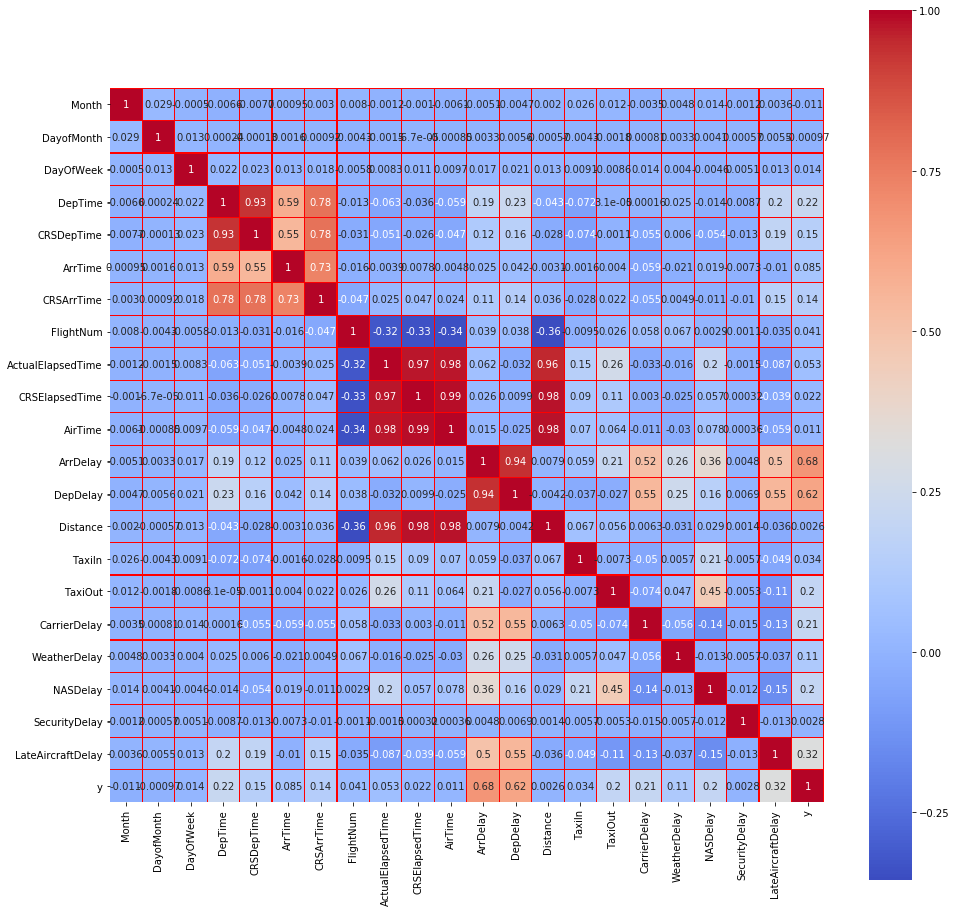

In [90]:
plt.figure(figsize=(16,16))
sns.heatmap(sample.corr(), cmap='coolwarm', square=True, annot=True, 
            linecolor='red', vmax=1, linewidth=.1)

**Feature correlation**

- All respective CRS values are highly correlated with actual values DepTime and CRSDepTime are highly correlated. Drop them. 
- Distance is higly correlated with Elapsed time and air time. Since airtime is an indicator of distance, removing distance.  

**Target variable correlation**

- y is correlated with arrival delay and departure delay 
- Other delay types are not quite correlated with it, drop them? 

In [99]:
sample = sample.drop(['CRSArrTime', 'CRSElapsedTime', 'Distance'], axis=1)

In [95]:
sample = sample.drop('CRSDepTime',axis=1)

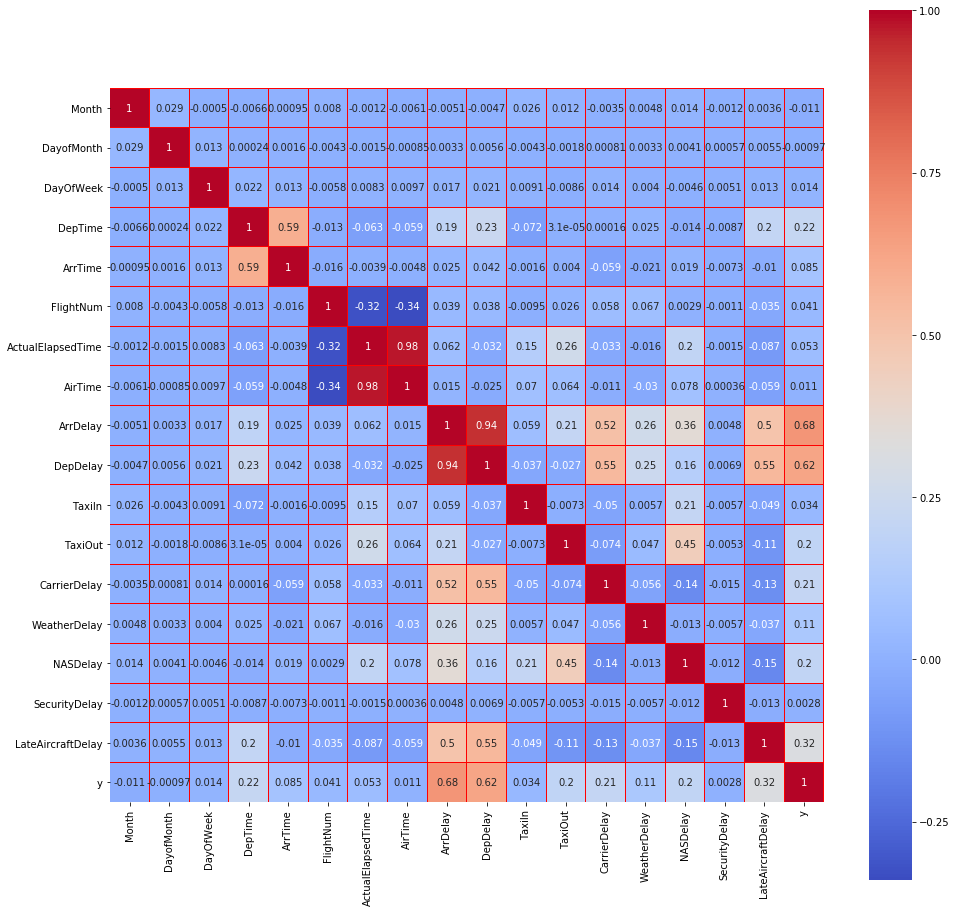

In [96]:
plt.figure(figsize=(16,16))
sns.heatmap(sample.corr(), cmap='coolwarm', square=True, annot=True, 
            linecolor='red', vmax=1, linewidth=.1)

### Feature engineering 

If the task is to predict the arrival delay in advance, certain features become useless as we would not know about them beforehand. For example, all delay variables are added posthoc. Hence, the features that we'll drop: 
 

